![](http://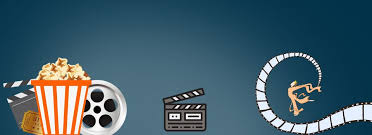)

# **INTRODUCTION**

Recommender Systems are used to generate recommendations. The two main types of recommender systems are either collaborative or content-based filters.

* Collaborative filters : This type of filter is based on users’ rates, and it will recommend us movies that we haven’t watched yet, but users similar to us have, and like. To determine whether two users are similar or not, this filter considers the movies both of them watched and how they rated them. By looking at the items in common, this type of algorithm will basically predict the rate of a movie for a user who hasn’t watched it yet, based on the similar users’ rates.

* Content-based filters : This type of filter does not involve other users if not ourselves. Based on what we like, the algorithm will simply pick items with similar content to recommend us.

* Hybrid Engine : Ideas brought together from content and collaborative filtering to build an engine that gave movie suggestions to a particular user based on the estimated ratings that it had internally calculated for that user.

# DATASET

### Context

These files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

# IMPORT LIBRARIES

In [1]:
import re
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import plotly
import plotly.io as pio
from os import path
from PIL import Image
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', 50)

# IMPORT DATASET

We're going to use only three files from the database, namely

* movies_metadata,
* credits,
* keywords.

In [2]:
#Loading the datasets
#metadata of the movies
md = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')
#movie credits
credits = pd.read_csv('/kaggle/input/the-movies-dataset/credits.csv') 
#movie keywords
keywords = pd.read_csv('/kaggle/input/the-movies-dataset/keywords.csv') 

# DATA PREPARATION

### credits.csv

In [3]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


***credits*** contains the cast, crew and id corresponding to various movies. As we can see, the cast and crew columns contains a list of dictionaries but it is in the form of strings somewhat resembling a JSON format. Hence we'll use literal_eval to convert in from string to list of dictionaries and then extract the Cast and Director from the Crew columns.

In [4]:
#Converting the string into list of dictionaries
credits.cast = credits.cast.apply(literal_eval)
credits.crew = credits.crew.apply(literal_eval)

In [5]:
# Extracting the Casts into a list from Dictionaries
credits['cast'] = credits['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [6]:
# Extracting the Director from the Crew
def extract_director(x):
    for crew_mem in x:
        if crew_mem['job'] == 'Director':
            return crew_mem['name']
        else:
            return np.nan

credits['director'] = credits['crew'].apply(extract_director)
credits['director'].fillna('',inplace = True)

In [7]:
credits.drop(['crew'],axis = 1,inplace = True)
credits.head()

,cast,id,director
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",862,John Lasseter
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",8844,
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",15602,Howard Deutch
3,"[Whitney Houston, Angela Bassett, Loretta Devi...",31357,Forest Whitaker
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...",11862,


### keywords.csv

In [8]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


***keywords*** contains the keywords and id corresponding to various movies. As we can see, the keywords columns contains a list of dictionaries but it is in the form of strings,similar to ***credits***. We'll handle it in a similar way.

In [9]:
#Converting the string into list of dictionaries
keywords.keywords = keywords.keywords.apply(literal_eval)

In [10]:
# Extracting the Keywords into a list from Dictionaries
keywords['keywords'] = keywords['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [11]:
keywords.head()

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence, aging, daug..."


## movies_metadata.csv

In [12]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [13]:
md.describe(include = 'all')

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
count,45466,4494,45466,45466,7782,45466,45449,45455,45466,44512,45461,45080,45463,45463,45379,4.546000e+04,45203.000000,45460,45379,20412,45460,45460,45460.000000,45460.000000
unique,5,1698,1226,4069,7673,45436,45417,92,43373,44307,44176,45024,22708,2393,17336,NaN,NaN,1931,6,20283,42277,2,NaN,NaN
top,False,"{'id': 415931, 'name': 'The Bowery Boys', 'pos...",0,"[{'id': 18, 'name': 'Drama'}]",http://www.georgecarlin.com,141971,tt1180333,en,Alice in Wonderland,No overview found.,0.0,/5D7UBSEgdyONE6Lql6xS7s6OLcW.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2008-01-01,NaN,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Cinderella,False,NaN,NaN
freq,45454,29,36573,5000,12,3,3,32269,8,133,34,5,11875,17851,136,NaN,NaN,22395,45014,7,11,45367,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.120935e+07,94.128199,NaN,NaN,NaN,NaN,NaN,5.618207,109.897338
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.433225e+07,38.407810,NaN,NaN,NaN,NaN,NaN,1.924216,491.310374
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,85.000000,NaN,NaN,NaN,NaN,NaN,5.000000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,95.000000,NaN,NaN,NaN,NaN,NaN,6.000000,10.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,107.000000,NaN,NaN,NaN,NaN,NaN,6.800000,34.000000


In [14]:
md[(md.adult != "True") & (md.adult != "False")]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Midnight Man,False,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Mardock Scramble: The Third Exhaust,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Beware Of Frost Bites,Avalanche Sharks,False,4.3,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The "adult" column has 5 values instead of 2 (True and False). So first let's handle this column itself.

For these three movies, the data seems to be all jumbled up amongst various columns. For example, adult column contains the overview and overview column contains the status etc. But actually the data is divided across two indices. So we combine the data into single index and drop the later index.

In [15]:
idx = [19729,29502,35586]
lst_1 = ['popularity', 'poster_path', 'production_companies','production_countries', 'release_date', 'revenue',
         'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']
lst_2 = ['belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 
         'overview','popularity', 'poster_path', 'production_companies','production_countries', 'release_date']
for i in idx:
    for col_seq in range(len(lst_1)):
            md[lst_1[col_seq]][i] = md[lst_2[col_seq]][i+1]

In [16]:
idx = [x+1 for x in idx]
md.drop(index = idx,inplace = True)

In [17]:
md.adult = md.adult.apply(lambda x : True if (x == 'True') else False)

genres are also in JSON format, so we'll handle it in the similar way we have handled it so far.

In [18]:
# Extracting the Genres into a list from Dictionaris
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [19]:
# Dropping Duplicates 
credits.drop_duplicates('id',inplace = True)
keywords.drop_duplicates('id',inplace = True)
md.drop_duplicates('id',inplace = True)

In [20]:
#Converting IDs into same data type
md.id = md.id.astype(int)

In [21]:
#Merging DataFrames into one
md = md.merge(credits, on = 'id', how = 'left')
md = md.merge(keywords, on = 'id', how = 'left')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,director,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,"[jealousy, toy, boy, friendship, friends, riva..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",,"[board game, disappearance, based on children'..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,"[fishing, best friend, duringcreditsstinger, o..."
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,"[based on novel, interracial relationship, sin..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...",,"[baby, midlife crisis, confidence, aging, daug..."


# SELECTING REQUIRED DATA

In [22]:
# Selecting required columns from the master dataframe
movies = md[['id','original_title','title','cast', 'director', 'keywords', 'genres', 'release_date', 'overview', 
             'original_language', 'adult', 'runtime', 'tagline', 'vote_average', 'vote_count','popularity']]
movies.head(30)

,id,original_title,title,cast,director,keywords,genres,release_date,overview,original_language,adult,runtime,tagline,vote_average,vote_count,popularity
0,862,Toy Story,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,"[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",1995-10-30,"Led by Woody, Andy's toys live happily in his ...",en,False,81.0,NaN,7.7,5415.0,21.9469
1,8844,Jumanji,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]",1995-12-15,When siblings Judy and Peter discover an encha...,en,False,104.0,Roll the dice and unleash the excitement!,6.9,2413.0,17.0155
2,15602,Grumpier Old Men,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,"[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]",1995-12-22,A family wedding reignites the ancient feud be...,en,False,101.0,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,11.7129
3,31357,Waiting to Exhale,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,"[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",1995-12-22,"Cheated on, mistreated and stepped on, the wom...",en,False,127.0,Friends are the people who let you be yourself...,6.1,34.0,3.85949
4,11862,Father of the Bride Part II,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...",,"[baby, midlife crisis, confidence, aging, daug...",[Comedy],1995-02-10,Just when George Banks has recovered from his ...,en,False,106.0,Just When His World Is Back To Normal... He's ...,5.7,173.0,8.38752
5,949,Heat,Heat,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...",Michael Mann,"[robbery, detective, bank, obsession, chase, s...","[Action, Crime, Drama, Thriller]",1995-12-15,"Obsessive master thief, Neil McCauley leads a ...",en,False,170.0,A Los Angeles Crime Saga,7.7,1886.0,17.9249
6,11860,Sabrina,Sabrina,"[Harrison Ford, Julia Ormond, Greg Kinnear, An...",Sydney Pollack,"[paris, brother brother relationship, chauffeu...","[Comedy, Romance]",1995-12-15,An ugly duckling having undergone a remarkable...,en,False,127.0,You are cordially invited to the most surprisi...,6.2,141.0,6.67728
7,45325,Tom and Huck,Tom and Huck,"[Jonathan Taylor Thomas, Brad Renfro, Rachael ...",,[],"[Action, Adventure, Drama, Family]",1995-12-22,"A mischievous young boy, Tom Sawyer, witnesses...",en,False,97.0,The Original Bad Boys.,5.4,45.0,2.56116
8,9091,Sudden Death,Sudden Death,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...",Peter Hyams,"[terrorist, hostage, explosive, vice president]","[Action, Adventure, Thriller]",1995-12-22,International action superstar Jean Claude Van...,en,False,106.0,Terror goes into overtime.,5.5,174.0,5.23158
9,710,GoldenEye,GoldenEye,"[Pierce Brosnan, Sean Bean, Izabella Scorupco,...",Martin Campbell,"[cuba, falsely accused, secret identity, compu...","[Adventure, Action, Thriller]",1995-11-16,James Bond must unmask the mysterious head of ...,en,False,130.0,No limits. No fears. No substitutes.,6.6,1194.0,14.686


In [23]:
# Missing Value
movies.isna().sum()

id                       0
original_title           0
title                    0
cast                     1
director                 1
keywords                 1
genres                   0
release_date            84
overview               954
original_language       11
adult                    0
runtime                257
tagline              25031
vote_average             0
vote_count               0
popularity               0
dtype: int64

### SUBSTITUTING NULL VALUES  

In [24]:
movies.original_language.fillna('',inplace = True)
# Fill NA of Tagline with empty strings
movies.tagline.fillna('',inplace = True)
# Fill NA of overview with empty strings
movies.overview.fillna('',inplace = True)
movies.loc[movies.overview == 'No overview found.','overview'] = ''
# Fill NA of runtime with 0
movies.runtime.fillna(0,inplace = True)

movies.cast = movies.cast.apply(lambda x: x if isinstance(x, list) else [])
movies.director.fillna('',inplace = True)
movies.keywords = movies.keywords.apply(lambda x: x if isinstance(x, list) else [])

# If the release_Date is missing, as of now we're putting the date of 2050-01-01 in order to be able to convert in into datetime object
movies.loc[movies['release_date'].isna(),'release_date'] = '2050-01-01'
movies.release_date = pd.to_datetime(movies.release_date,format = '%Y-%m-%d')

In [25]:
movies.head(5)

,id,original_title,title,cast,director,keywords,genres,release_date,overview,original_language,adult,runtime,tagline,vote_average,vote_count,popularity
0,862,Toy Story,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,"[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",1995-10-30,"Led by Woody, Andy's toys live happily in his ...",en,False,81.0,,7.7,5415.0,21.9469
1,8844,Jumanji,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]",1995-12-15,When siblings Judy and Peter discover an encha...,en,False,104.0,Roll the dice and unleash the excitement!,6.9,2413.0,17.0155
2,15602,Grumpier Old Men,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,"[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]",1995-12-22,A family wedding reignites the ancient feud be...,en,False,101.0,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,11.7129
3,31357,Waiting to Exhale,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,"[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",1995-12-22,"Cheated on, mistreated and stepped on, the wom...",en,False,127.0,Friends are the people who let you be yourself...,6.1,34.0,3.85949
4,11862,Father of the Bride Part II,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...",,"[baby, midlife crisis, confidence, aging, daug...",[Comedy],1995-02-10,Just when George Banks has recovered from his ...,en,False,106.0,Just When His World Is Back To Normal... He's ...,5.7,173.0,8.38752


# DATA PREPROCESSING

## !!! Takes a lot of time, so a csv file has been saved, use that !!!

Due to the limited computing strength available only around 45%(20,000 rows) of the data has been used to work upon.

In [26]:
movies["popularity"] = pd.to_numeric(movies["popularity"], downcast="float")
movies = movies.sort_values(by='popularity',axis=0, ascending=False)[0:20000].reset_index()
movies=movies.drop(['index'], axis=1)
movies.head(5)

,id,original_title,title,cast,director,keywords,genres,release_date,overview,original_language,adult,runtime,tagline,vote_average,vote_count,popularity
0,211672,Minions,Minions,"[Sandra Bullock, Jon Hamm, Michael Keaton, All...",,"[assistant, aftercreditsstinger, duringcredits...","[Family, Animation, Adventure, Comedy]",2015-06-17,"Minions Stuart, Kevin and Bob are recruited by...",en,False,91.0,"Before Gru, they had a history of bad bosses",6.4,4729.0,547.488281
1,297762,Wonder Woman,Wonder Woman,"[Gal Gadot, Chris Pine, Robin Wright, Danny Hu...",,"[dc comics, hero, greek mythology, island, wor...","[Action, Adventure, Fantasy]",2017-05-30,An Amazon princess comes to the world of Man t...,en,False,141.0,Power. Grace. Wisdom. Wonder.,7.2,5025.0,294.337036
2,321612,Beauty and the Beast,Beauty and the Beast,"[Emma Watson, Dan Stevens, Luke Evans, Kevin K...",Bill Condon,"[france, magic, castle, fairy tale, musical, c...","[Family, Fantasy, Romance]",2017-03-16,A live-action adaptation of Disney's version o...,en,False,129.0,Be our guest.,6.8,5530.0,287.253662
3,339403,Baby Driver,Baby Driver,"[Ansel Elgort, Lily James, Kevin Spacey, Jamie...",,"[robbery, atlanta, music, crime boss, romance,...","[Action, Crime]",2017-06-28,After being coerced into working for a crime b...,en,False,113.0,All you need is one killer track.,7.2,2083.0,228.032745
4,177572,Big Hero 6,Big Hero 6,"[Scott Adsit, Ryan Potter, Daniel Henney, T.J....",,"[brother brother relationship, hero, talent, r...","[Adventure, Family, Animation, Action, Comedy]",2014-10-24,The special bond that develops between plus-si...,en,False,102.0,From the creators of Wreck-it Ralph and Frozen,7.8,6289.0,213.849915


In [27]:
#combining the overview and taglines
movies['plot_corpus'] = movies['overview'] + movies['tagline']

def listtostr(txt):
    '''
    Returns string by joining the elements of the list
    '''
    
    txt_clean = ' '.join([str(elem) for elem in txt])
    return txt_clean

movies['keywords'] = movies['keywords'].apply(listtostr)
movies['genres'] = movies['genres'].apply(listtostr)

#movies['plot_corpus_1'] = movies['overview'] + movies['tagline'] + movies['keywords']
movies['genre_corpus'] = movies['keywords'] + movies['genres']

## Text cleaning
Before vectorization a certain level of cleaning is required. This includes:
* Removing punctuations
* Converting the text documents to lower case
* Removing the stopwords: Stopwords are the English words which do not add much meaning to a sentence. They can safely be ignored      without sacrificing the meaning of the sentence. For example, the words like the, he, have etc
* Lemmatization : Lemmatization is the process of converting a word to its base form. 

**Note** : Another way of reducing words to their root form is stemming. But stemming just removes the last few characters, often leading to incorrect meanings and spelling errors whereas lemmatization considers the context and converts the word to its meaningful base form, we decided to use the latter. 

In [28]:
def get_wordnet_pos(word):
    '''
    Returns the tag for the word
    '''
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer=WordNetLemmatizer()

def clean_plot(txt):
    '''
    Returns the cleaned plot text 
    '''
    
    regex = re.compile(r"[!@%&;?'',.""-]")
    txt_clean = re.sub(regex,'',txt)
    txt_clean = txt_clean.lower()
    txt_clean = txt_clean.split(' ')
    txt_clean = [word for word in txt_clean if word not in stopwords.words('english')]
    txt_clean = ' '.join(txt_clean)
    word_list = nltk.word_tokenize(txt_clean)
    txt_clean = ' '.join([lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in word_list])
    return txt_clean

def clean_cast(txt):
    '''
    Returns the cleaned cast string
    '''
    
    for i in range(len(txt)):
        txt[i] = re.sub(r"[.,']","",txt[i])
        txt[i] = re.sub(r"[-]"," ",txt[i])
        txt[i] = re.sub(" ","_",txt[i])
        txt[i] = txt[i].lower()
    return txt

def clean_director(txt):
    '''
    Returns the cleaned director string
    '''
    
    txt_clean = re.sub(r"[.,']","",txt)
    txt_clean = re.sub(r"[-]"," ",txt_clean)
    txt_clean = re.sub(" ","_",txt_clean)
    txt_clean = txt_clean.lower()
    return txt_clean

In [29]:
movies['plot_corpus'] = movies['plot_corpus'].apply(clean_plot)
movies['genre_corpus'] = movies['genre_corpus'].apply(clean_plot)
movies['genre_pure'] = movies['genres'].apply(clean_plot)

In [30]:
movies['genre_pure']

0               family animation adventure comedy
1                        action adventure fantasy
2                          family fantasy romance
3                                    action crime
4        adventure family animation action comedy
                           ...                   
19995                                      comedy
19996                       drama fantasy romance
19997                     action foreign thriller
19998                                      comedy
19999                                 crime drama
Name: genre_pure, Length: 20000, dtype: object

In [31]:
movies['cast'] = movies['cast'].apply(clean_cast)
movies['cast'] = movies['cast'].apply(listtostr)
movies['director'] = movies['director'].apply(clean_director)

In [32]:
movies['genre_corpus'] = movies['genre_corpus'] + movies['cast']
movies['mixed_corpus'] = movies['genre_corpus'] + movies['plot_corpus']

## Vectorization 
In order to perform further operations on our text, we need to transform our documents into vector representations such that we can apply numeric machine learning. This process is called vectorization.For vectorization of text corpuses (or columns) "CountVectorizer" and "Tfidfvectorizer"have been used.

"CountVectorizer" counts the word frequencies. With the "TfidfVectorizer" the value increases proportionally to count, but is inversely proportional to frequency of the word in the corpus; that is the inverse document frequency (IDF) part. The IDF feature of the tfidf vectorizer helps in dealing with the redundancy that might be caused by common words in a corpus consisting of sentences such as our overview column."Tfidfvectorizer" has been used to vectorize the 'plot corpus' and countevectorizer to vectorize genre,cast and director columns.

In [33]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df = 0, stop_words = 'english')
cv = CountVectorizer(analyzer = 'word', ngram_range = (1,2), min_df = 0, stop_words = 'english')

plot_vector = tf.fit_transform(movies['plot_corpus'])
genre_vector = cv.fit_transform(movies['genre_corpus'])
cast_vector = cv.fit_transform(movies['cast'])
director_vector = cv.fit_transform(movies['director'])
genre_only_vector = cv.fit_transform(movies['genre_pure'])


## SIMILARITY MEASURES
There are various metrics to calculate the similarity score of the vectorized documents. Cosine similarity has been used here.
Cosine similarity is a metric used to measure how similar the documents are irrespective of their size. The smaller the angle, higher the cosine similarity. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still be oriented closer together. 

The cosine similarity function returns a returns a pairwise cosine similarity matrix for the vector input. When stored in a dataframe, each row represents the similarity score of a particular movies with respect to all the other movies.

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

plot_score = cosine_similarity(plot_vector,plot_vector)
genre_score = cosine_similarity(genre_vector,genre_vector)
cast_score = cosine_similarity(cast_vector,cast_vector)
director_score = cosine_similarity(director_vector, director_vector)
genre_only_score = cosine_similarity(genre_only_vector,genre_only_vector)

plot_score = pd.DataFrame(plot_score)
genre_score = pd.DataFrame(genre_score)
cast_score = pd.DataFrame(cast_score)
director_score = pd.DataFrame(director_score)
genre_only_score = pd.DataFrame(genre_only_score)

Calculating average of the ratings alotted by various users would give biased results because of the discrepancy in the number of ratings each movie received. Instead we use the weighted rating formulae.


In [35]:
vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)

print(C,m)

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

movies['wr'] = movies.apply(weighted_rating, axis=1)

5.6916 1101.0


There are a total of 151 movies with 0 votes,but no movie has a popularity of 0.
So we can get a weighted average of votes of similar movies in the same genres and also weigth it on the popularity of the corresponding movie.

In [36]:
movies['genres'] = movies['genres'].apply(lambda x : x.split())
movies['release_year'] = movies.release_date.apply(lambda x: x.year)

In [37]:
def score(value,index_list,feature):
    '''
    Returns list of scores for the passed feature
    '''
    if feature == 'genre':
        df_temp = pd.DataFrame(genre_only_score[value])
    if feature == 'plot':
        df_temp = pd.DataFrame(plot_score[value])
    if feature == 'plot_1':
        df_temp = pd.DataFrame(plot_score_1[value])
    if feature == 'cast':
        df_temp = pd.DataFrame(cast_score[value])
    if feature == 'director':
        df_temp = pd.DataFrame(director_score[value])
    df_temp = df_temp.loc[df_temp.index.isin(index_list)]
    my_list = df_temp[value].tolist()
    return my_list

    

## MODEL KEY POINTS 
* Arrange movies in the descending order by their genre similarity score with respect to the target film.
* Cluster the movies received from the previous step based on their plot scores.
* Further sort movies(in descending order) within each cluster on the basis of all the similarity scores(previously calculated) and their calculated weighted ratings.
* Return the top fifty recommendations from each cluster

In [38]:
def get_feature_set(df1,df2,df3,title):
    
    '''
    idx : index value of the target movie
    top : index value of top 500 movies(sorted(descending) by genre similarity score w.r.t. target movie)
    feature_set : Data frame containing plot score matrix of movies which had their index in "top"
    movie_set : Name of the movies which had their index in "top"
    '''   
    
    idx = movies.index[movies.title == title].values.astype(int)[0]
    top = df1[idx].sort_values(ascending = False)[0:500].index.values.tolist()
    top = df1[idx].sort_values(ascending = False)[0:500].index.values.tolist()
    feature_set = df2[df2.index.isin(top)]
    movies_set = pd.DataFrame(movies.loc[movies.index.isin(top),'title'])
    return feature_set,movies_set

def get_recommendations(title,cluster_num,df1=genre_score,df2=plot_score,df3=cast_score):
    
    '''
    movie_set = dataframe to store the cluster labels(1,2,3) assigned to movies along with their similarity scores and ratings
    df_recommend = dataframe with information about the top 50 movies recommended from each cluster
    '''
    
    feature_set,movies_set = get_feature_set(df1,df2,df3,title)
    cluster_algo = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster = cluster_algo.fit(feature_set)
    movies_set['cluster'] = cluster.labels_
    index = movies_set.index.values.tolist()
    idx = movies.index[movies.title == title].values.astype(int)[0]
    movies_set.loc[movies_set.index.isin(index),'wr'] = movies.loc[movies.index.isin(index),'wr']
    movies_set.loc[movies_set.index.isin(index),'p_score'] = score(idx,index,'plot')
    movies_set.loc[movies_set.index.isin(index),'g_score'] =score(idx,index,'genre')
    movies_set.loc[movies_set.index.isin(index),'c_score'] = score(idx,index,'cast')
    movies_set.loc[movies_set.index.isin(index),'d_score'] = score(idx,index,'director')
    target_cluster = movies_set.loc[movies_set.title == title, 'cluster'].values[0]
    if(target_cluster!=0):
        movies_set.loc[movies_set.cluster==target_cluster,'cluster'] = 100
        movies_set.loc[movies_set.cluster==0,'cluster'] = target_cluster
        movies_set.loc[movies_set.cluster==100,'cluster'] = 0
    if(cluster_num==1):
        recommend_1 = movies_set[movies_set.cluster == 0] 
        df_recommend = pd.DataFrame(recommend_1.sort_values(['g_score','p_score','c_score','d_score', 'wr'],ascending=[False,False,False,False,False])[1:50].title)
    if(cluster_num==2):
        recommend_1 = movies_set[movies_set.cluster == 1] 
        df_recommend = pd.DataFrame(recommend_1.sort_values(['g_score','p_score','c_score','d_score', 'wr'],ascending=[False,False,False,False,False])[1:50].title)
    if(cluster_num==3):
        recommend_1 = movies_set[movies_set.cluster == 2] 
        df_recommend = pd.DataFrame(recommend_1.sort_values(['g_score','p_score','c_score','d_score', 'wr'],ascending=[False,False,False,False,False])[1:50].title)
    df_recommend.loc[df_recommend.index.isin(index),'genres'] = movies.loc[movies.index.isin(index),'genre_pure']
    df_recommend.loc[df_recommend.index.isin(index),'title'] = movies.loc[movies.index.isin(index),'title']
    df_recommend.loc[df_recommend.index.isin(index),'director'] = movies.loc[movies.index.isin(index),'director']
    df_recommend.loc[df_recommend.index.isin(index),'cast'] = movies.loc[movies.index.isin(index),'cast']
    df_recommend.loc[df_recommend.index.isin(index),'ratings'] = movies.loc[movies.index.isin(index),'wr']
    df_recommend.loc[df_recommend.index.isin(index),'adult'] = movies.loc[movies.index.isin(index),'adult']
    df_recommend['ratings'] = df_recommend['ratings'].round(decimals=2)
    return df_recommend

## VISUALIZATION
After we have the recommendations we need to present it in a way that is easy to comprehend.
* We are going to print top ten recommendations from each cluster.
* Wordclouds to represent prominent genres, casts and directors in each cluster.
> (Word clouds or tag clouds are graphical representations of word frequency that give greater prominence to words that appear more frequently in a source text. The larger the word in the visual the more common the word was in the document(s).We are going to make three wordclouds for each cluster.)
* Pie chart to represent genre frequency in each cluster
* A barchart to represent maximum, minimum and average ratings of each cluster



In [39]:
def cluster_class(title,cl_num):
    '''
    converts each column of the recommendation dataframe into list
    '''
    df = get_recommendations(title,cluster_num=cl_num)
    cast = ' '.join(df.cast.tolist())
    genre = ' '.join(df.genres.tolist())
    director = ' '.join(df.director.tolist())
    ratings = df.ratings.tolist()
    return df,cast,director,genre,ratings,cl_num

In [40]:
class recommended_cluster:
    '''
    movies   : A dataframe of movies with other information within a cluster
    cast     : A list of cast for the movies within a cluster
    director : A list of directors for the movies within a cluster
    genre    : A list of genres of the movies within a cluster
    ratings  : A list of ratings of the movies within a cluster
    
    '''
   
    def __init__(self,cluster_tuple):
        self.movies = cluster_tuple[0]
        self.cast = cluster_tuple[1]
        self.director = cluster_tuple[2]
        self.genre = cluster_tuple[3]
        self.ratings = cluster_tuple[4]
        self.cl_num = cluster_tuple[5]
        
    def recommended_movie(self):
        '''
        generates a table containing top 10 recommendations from each cluster along with their corresponding ratings
        '''
        df = self.movies[0:10]
        fig = go.Figure(data=[go.Table(header = dict(values = ['Title','Rating'],
                                                     font = dict(size=15),
                                                     align = "center"),
                                       cells = dict(values = [df.title,df.ratings],
                                                    align = "center")
                                      )
                             ]
                       )
        fig.show()    
    
    
    def cast_cloud(self):
        '''
        generates a wordcloud of casts present in a cluster
        '''
        wordcloud = WordCloud(random_state=1,
                              background_color='black', colormap='Blues_r',
                              collocations=False, stopwords = STOPWORDS).generate(self.cast)
        return wordcloud

    def director_cloud(self):
        '''
        generates a wordcloud of directors present in a cluster
        '''
        wordcloud = WordCloud(random_state=1,
                              background_color='black', colormap='Blues_r',
                              collocations=False, stopwords = STOPWORDS).generate(self.director)
        return wordcloud

        
    def genre_cloud(self):
        '''
        generates a wordcloud of genres present in a cluster
        '''
        wordcloud = WordCloud(random_state=1,
                              background_color='black', colormap='Blues_r',
                              collocations=False, stopwords = STOPWORDS).generate(self.genre)
        return wordcloud

    
    def get_wordcloud(self):
        '''
        plots the cast, genre and director wordclouds in the from of subplots 
        '''
        fig = plt.figure(figsize=(30,10))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)

        font = FontProperties()
        font.set_family('serif')
        font.set_name('Times New Roman')
        font.set_size(40)

        def nulltick(ax):
            '''
            removes the ticks from x and y axis of the wordcloud plots
            '''
            ax.xaxis.set_major_locator(ticker.NullLocator())
            ax.xaxis.set_minor_locator(ticker.NullLocator())
            ax.yaxis.set_major_locator(ticker.NullLocator())
            ax.yaxis.set_minor_locator(ticker.NullLocator())
        
        ax1.imshow(self.genre_cloud(), interpolation='bilinear')
        nulltick(ax1)
        ax1.set_xlabel("GENRE WORDCLOUD",fontproperties = font)
        ax2.imshow(self.cast_cloud(), interpolation='bilinear')
        nulltick(ax2)
        ax2.set_xlabel("CAST WORDCLOUD",fontproperties = font)
        ax3.imshow(self.director_cloud(), interpolation='bilinear')
        nulltick(ax3)
        ax3.set_xlabel("DIRECTOR WORDCLOUD",fontproperties = font)
        
        fig.suptitle('CLUSTER '+str(self.cl_num), fontsize=60)
        fig.tight_layout()
        plt.show()
    
    def pie_data(self):
        '''
        returns a dataframe with frequency of occurence of genres in a cluster
        '''
        wordlist = self.genre.split()
        wordfreq = [wordlist.count(p) for p in wordlist]
        dictionary = dict(list(zip(wordlist,wordfreq)))
        lst = list(dictionary.items())
        df = pd.DataFrame(lst)
        df.columns =['Genre','Frequency']
        return df

    def get_piechart(self):
        '''
        plots the frequency of occurence of genres in a cluster in the form of a piechart
        '''
        df = self.pie_data()
        values = df['Frequency']
        labels = df['Genre']
        fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
        fig.show()
        
        
    def get_ratings(self):
        '''
        calculates the minimum, maximum and average rating of a cluster
        '''
        minima = min(self.ratings)
        maxima = max(self.ratings)
        avg = sum(self.ratings)/len(self.ratings)
        return round(minima,2),round(maxima,2),round(avg,2)
    
    def ratings_chart(self):
        '''
        plots the minimum, maximum and average rating of a cluster in the form of a bar chart 
        '''
        minima,maxima,avg = self.get_ratings()
        fig = go.Figure(data=[
            go.Bar(name='Minimum Rating', x=['CLUSTER '+str(self.cl_num)], y=[minima], text=minima,textposition='outside',width = [0.2,0.2,0.2],marker_color = 'indianred'),
            go.Bar(name='Average Rating', x=['CLUSTER '+str(self.cl_num)], y=[avg],text=avg,textposition='outside', width = [0.2,0.2,0.2],marker_color = 'blue'),
            go.Bar(name='Maximum Rating', x=['CLUSTER '+str(self.cl_num)], y=[maxima],text=maxima,textposition='outside', width = [0.2,0.2,0.2], marker_color = 'green')
        ])
        fig.update_yaxes(range=[1, 10],dtick=1)
        fig.show()
   

In [41]:
def Dashboard(title):
    for i in [1,2,3]:
        cluster = recommended_cluster(cluster_class(title,i))
        cluster.get_wordcloud()
        cluster.recommended_movie()
        cluster.get_piechart()
        cluster.ratings_chart()